In [1]:
%pylab inline

import plt_fmt
def matprint(M):
    """
    Makes a pretty printing of a square matrix
    """
    for item in M:
        for val in item:
            print('{0:.3f}'.format(val).rjust(6),end=" ")
        print('\n')
sin(.1*2*pi)/(2*pi)


from scipy.special import gamma, gammainc
from math import factorial
from scipy.linalg import eig, inv

def matcrunch(tmat):
    """
    Given a transition matrix, remove every other column in
    order to enforce a symmetry requirement
    """
    newmat = tmat[::2,:]
    outmat = newmat[:,::2]
    return outmat


def expm_exact(mat):
    """
    Given a diagonalizable matrix, compute the exact matrix exponential
    """
    dd = eig(mat)[1]
    eigvals = eig(mat)[0]
    
    exped = diag( exp(eigvals) )
    
    return real(dd.dot( exped.dot(inv(dd)) ))

def dirty_gammainc(k, x):
    """
    A wrapper for the numpy incomplete gamma function that treats
    the zero case separately from the other cases
    
    TODO: treat all integers as special cases with a truncated summation
    
    k : int
    
    x : double
    """
    
    k = int(k)
    
    if k == 1:
        return exp(-x)
    elif k > 1:
        return gammainc(k, x)
    else:
        print ("Bad input")
        return nan

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.special import gamma, gammainc
from math import factorial
from scipy.linalg import eig, inv


def expm_exact(mat):
    """
    Given a diagonalizable matrix, compute the exact matrix exponential
    """
    dd = eig(mat)[1]
    eigvals = eig(mat)[0]
    
    exped = diag( exp(eigvals) )
    
    return real(dd.dot( exped.dot(inv(dd)) ))

def dirty_gammainc(k, x):
    """
    A wrapper for the numpy incomplete gamma function that treats
    special cases separately from the general case
    
    k : int
    
    x : double
    """
    
    k = int(k)
    
    if k == 1:
        return exp(-x)
    elif k > 1:
        return gammainc(k, x)
    else:
        print ("Bad input")
        return nan
    
def dirtier_gammainc(k, x):
    """
    A full alternative to the numpy incomplete gamma function that
    avoids taking nasty integrals but which runs slower 
    and is also terrible.

    
    k : int
    
    x : double
    
    INCOMPLETE CURRENTLY
    """
    
    k = int(k)
    
    if k == 1:
        return exp(-x)
    elif k > 1:
        return gammainc(k, x)
    else:
        print ("Bad input")
        return nan

def amat(m,n,a=nan,k=nan,L=nan):
    """
    m : int
    
    n : int
    
    Defaults are set so that strange behavior occurs unless the 
    value is explicitly passed
    
    Terrible rounding errors will occur if m, n are passed as doubles
    TODO: Vectorize this properly
    
    """
    
    if any(isnan((a,k,L))):
        print ("Parameter values were left unset")
    
    if m == n == 0:
        return -k*a
#         return 0

    if mod(n-m, 2) != 0:
        return 0
    
    if mod(n+m, 2) != 0:
        return 0
    
    if n == m:
        element1 = -k*a + -k*L*((-1)**n*sin(a/L*n*pi))/(n*pi)
#         element1 = -k*L*((-1)**n*sin(a/L*n*pi))/(n*pi)
    elif (n != 0 and m==0):
        element1 = -2*sqrt(2)*k*L*cos(n*pi/2)*sin(a/L*n*pi/2)/(n*pi)
    elif (m != 0 and n==0):
        element1 = -2*sqrt(2)*k*L*cos(m*pi/2)*sin(a/L*m*pi/2)/(m*pi) 
    else:   
        p1 = int((n+m)/2)
        p2 = int((n-m)/2)

        element1 = -(k*L/pi)*(   (-1)**p1*sin(pi*p1*a/L)/(2*p1)\
                               +  (-1)**p2*sin(pi*p2*a/L)/(2*p2)       )

    return element1
amat = vectorize(amat)


def gmat(m,n,t=0.0,L=1.0,D=1.0e-1,alp=1.0):
    """
    Calculate the time-dependent part of the state transition matrix
    for the square well perturbed system
    
    make sure that m and n are ints
    
    TODO: Vectorize this properly
    """
    
    if m == n:
        element2 = t

    else:
        (lamb_m, lamb_n) = ( (ind*pi/L)**2 for ind in (m,n) )

        denominator = D*(lamb_m - lamb_n)**(1/alp)

        numerator = gamma( (alp + 1)/alp ) - \
        (1/alp)*dirty_gammainc(1/alp, (D*(lamb_m - lamb_n))*(t**alp))
#         numerator = 1 - exp(-D*t*(lamb_m - lamb_n))

        element2 = numerator/denominator

    if isnan(element2):
        element2 = 0.0
        print ("You got a NaN!: ")
        print ((m,n))
        print ((numerator,denominator))
        print('\n')


    return element2
gmat = vectorize(gmat)


def eigenfunctions(x, n, L=nan):
    """
    The unperturbed eigenfunctions of the infinite square well
    
    x : array
        array of values over which to define the function
        
    n : int
        the mode to use
        
    L : double
        the width of the confining potential
        
    Returns
    -------
    
    out : array
        A vector sampling of the n^{th} eigenmode of the square well
    
    """
    
    if n == 0:
        return ones(len(x))
    elif n > 0:
        return sqrt(2)*cos(pi*n*(x/L + 1/2))
    else:
        print ("Bad arguments")
        return nan
    

    
def sum_eigen(x, coeff, L=1.0,ignore='none'):
    """
    coeff : array
        a vector of coefficients of for the various modes
        of the square well
    
    x : array
        The sequence of values over which to construct the function
        
    Returns
    -------
    
    out : array
        A weighted combination of the provided modes
    
    """
    
    out = zeros(len(x))
    
    for (ind, c) in enumerate(coeff):
        if ignore =='odd':
            out += c*eigenfunctions(x, 2*ind, L=L)
        elif ignore =='even':
            out += c*eigenfunctions(x, 2*ind+1, L=L)
        elif ignore == 'none':
            out += c*eigenfunctions(x, ind, L=L)
        else:
            print ('Bad Keyword for ignore')
            out += c*eigenfunctions(x, ind, L=L)
    
    return out
 

def expm2(mat):
    """
    A simple alternative to numpy's matrix exponential function
    which uses truncation instead of Pade approximants
    """
    out = 1 + mat + (mat**2)/2 + (mat**3)/6 + (mat**4)/(24)
    
    return out


In [3]:
from scipy.linalg import expm

n_modes = 150
Lval = 1.0e0
aval = 0*.321*Lval
kval = 1.e11
Dval = 1.e-6

xvals = linspace(-.5*Lval,.5*Lval,5000)

(x,y) = meshgrid(range(n_modes), range(n_modes))

times = linspace(0,.0005,5)

# pre-compute the little-a matrix
amat_full = matcrunch(amat_delta(x,y, L=Lval,a=aval,k=kval))

figure()
hold(True)
for time in times:
    gmat_full = matcrunch(gmat(x,y, t=time,L=Lval,D=Dval,alp=1.0))
    tmat = expm_exact(amat_full*gmat_full)
    coeffs = zeros(n_modes/2) # remove the factor of two if symmetry goes away
    coeffs[0] = 1.0
    coeffs = tmat.dot(coeffs)
    sol = sum_eigen(xvals,coeffs,ignore='odd',L=Lval)
    
#     gker = (1./7)*ones(7)
#     sol = convolve(sol, gker,'same')
    plot(xvals, sol,'.')
    print("time: " + str(time))

xlim([xvals[0], xvals[-1]])
# ylim([.955,1.05]) # good for k=5e1, 100 modes
# ylim([-.05,1.05]) # good for k=5e1, 100 modes

rcParams['font.family'] = 'Myriad Pro Bold'
xlabel('Position within well')
ylabel('Concentration')
# savefig('xxdraining.pdf')

NameError: name 'amat_delta' is not defined

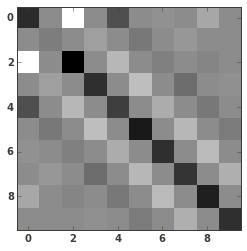

In [179]:
imshow(amat(x,y, L=Lval,a=aval,k=kval)[:10,:10])

## Simulate coupled coefficients ##

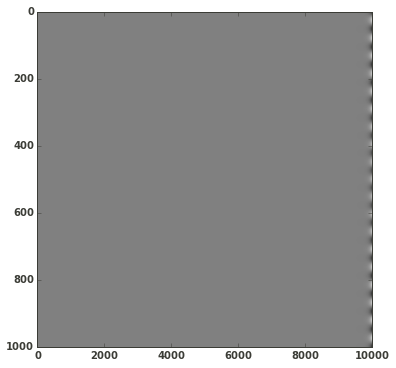

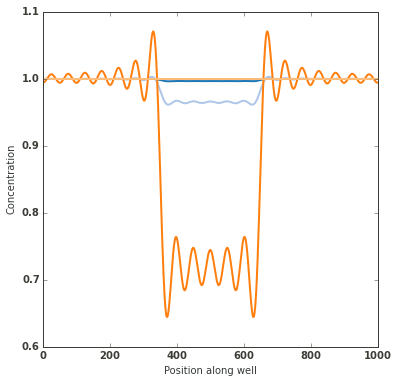

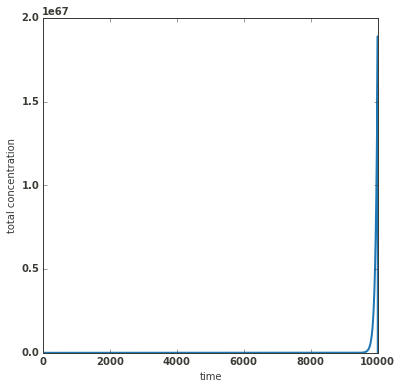

In [253]:
# WHERE DOES THE DIFFUSION COEFFICIENT GO?

n_modes = 40 # number of coupled modes to simulate

time_pts = 10000
actual_time = .8

space_pts = 1000
Lval = 1.0

def nxt_step_coeff(gvals, dt, amat):
    """
    
    gvals : array
        the ordered array of values of the coefficients of the various 
        unperturbed eigenfunctions at the previous timestep
        
    """
    
    Dc = .06
    
    Ln = 1.0
    
    L = len(gvals)
    nxt_vals = zeros(L)
    
    # unperturbed evolution
    indices = array([item for item in range(L)])
    eigenvalues = Dc*(pi*indices/Ln)**2
    eigenvalues[0] = 0.0
    nxt_vals += gvals*eigenvalues
    
    nxt_vals += amat.dot(gvals)
   
    return gvals + dt*nxt_vals


dt = actual_time/time_pts

g0 = zeros(n_modes/2)
g0[0] = 1.0



(x,y) = meshgrid(range(n_modes), range(n_modes))
amat_full = matcrunch(amat(x,y, L=Lval,a=.3,k=40))

sol = euler_mesh(g0, nxt_step_coeff, 0.0, actual_time, dt, [amat_full])

xvals = linspace(-.5,.5,space_pts)

mesh_sol = zeros([time_pts, space_pts]) 
for (rind, row) in enumerate(sol.T):
    comb = sum_eigen(xvals,row,ignore='odd',L=1.0)
    mesh_sol[rind-1, :] = comb
#     plot(xvals, comb)
    
# ylim([0, 1.05])

figure()
imshow(mesh_sol.T, aspect='auto')


figure()
plot(mesh_sol.T[:,0])
hold(True)
plot(mesh_sol.T[:,10])
plot(mesh_sol.T[:,100])
plot(mesh_sol.T[:,-1])
rcParams['font.family']='Myriad Prodd'
xlabel("Position along well")
ylabel("Concentration")
# savefig('Square well coupled prediction 2.pdf')

figure()
total_conc = sum(mesh_sol.T,axis=0)
plot(total_conc)
xlabel("time")
ylabel("total concentration")


In [ ]:
sol = sum_eigen(xvals,coeffs,ignore='odd',L=Lval)
plot(xvals, sol,'.')

In [11]:

def amat_delta(m,n,a=nan,k=nan,L=nan):
    """
    m : int
    
    n : int
    
    Defaults are set so that strange behavior occurs unless the 
    value is explicitly passed
    
    Terrible rounding errors will occur if m, n are passed as doubles
    TODO: Vectorize this properly
        
    """
    
    if any(isnan((a,k,L))):
        print ("Parameter values were left unset")
    
    if m == n == 0:
        return -k
#         return 0

    if mod(n-m, 2) != 0:
        return 0
    
    if mod(n+m, 2) != 0:
        return 0
    
    if (n != 0 and m==0):
        element1 = -k*sqrt(2)*cos(n*pi/2)
    elif (m != 0 and n==0):
        element1 = -k*sqrt(2)*cos(m*pi/2)
    else:   
        p1 = int((n+m)/2)
        p2 = int((n-m)/2)

        element1 = -k*(   cos(pi*p1) + cos(pi*p2)      )

    return element1
amat_delta = vectorize(amat_delta)


## 1D harmonic potential

In [4]:
from scipy.special import binom, hermite, factorial

def harmonic_eigenfunctions(x,n,betak=1.0):  
    values = sqrt(sqrt(betak)/(factorial(n)*2**n*sqrt(2*pi)))*exp(-(1/4)*betak*x**2)*hermite(n)(x)
    return values

def gmat(m,n,t=0.0, D=nan, alp=nan, betak=nan):
    """
    Calculate the time-dependent part of the state transition matrix
    for the square well perturbed system
    
    make sure that m and n are ints
    
    TODO: Vectorize this properly
    """
    
    assert ~any(isnan([D, alp, betak]))
    
    if m == n:
        element2 = t

    else:
        (lamb_m, lamb_n) = ( ind*betak for ind in (m,n) )

        denominator = D*(lamb_m - lamb_n)**(1/alp)

        numerator = gamma( (alp + 1)/alp ) - \
        (1/alp)*dirty_gammainc(1/alp, (D*(lamb_m - lamb_n))*(t**alp))
#         numerator = 1 - exp(-D*t*(lamb_m - lamb_n))

        element2 = numerator/denominator
    
    assert ~isnan(element2)
    return element2
gmat = vectorize(gmat)

def amat_1dharmonic(m, n, kappa=nan, gam=nan):
    """
    Generate the matrix elements for a first-order reaction perturbation
    to a harmonic potential
    
    This code has been checked agains Mathematica for correctness
    """
    # Don't bother with the odd elements for now
    if mod(n,2)!=0:
        tot = 0
    elif mod(m,2)!=0:
        tot = 0
    else:
        # swap indices if binomial theorem is going to break down
        if m<n:
            (m,n) = (n,m)

        tot = 0.0
        for k in range(0,n+1):
            weirdex = m - n + 2.*k
            tot += binom(m, n-k) * (1/(2.**k * factorial(k))) * sqrt(pi/(gam+1))*\
            (factorial(weirdex)/factorial(weirdex/2)) * ((-gam/(1+gam))**(weirdex/2.))
        tot = (2**n)*factorial(n)*tot
        tot = (-kappa/sqrt(pi))*sqrt(1/(factorial(n)*factorial(m)))*sqrt(1/(2**(m+n)))*tot
        
    return tot
amat_1dharmonic = vectorize(amat_1dharmonic)

def sum_eigen_harmonic(x, coeff, betak=nan, ignore='none'):
    """
    coeff : array
        a vector of coefficients of for the various modes
        of the harmonicwell
    
    x : array
        The sequence of values over which to construct the function
        
    Returns
    -------
    
    out : array
        A weighted combination of the provided modes
    
    """
    
    out = zeros(len(x))
    
    for (ind, c) in enumerate(coeff):
        if ignore =='odd':
            out += c*harmonic_eigenfunctions(x, 2*ind, betak=betak)
        elif ignore =='even':
            out += c*harmonic_eigenfunctionss(x, 2*ind+1, betak=betak)
        elif ignore == 'none':
            out += c*harmonic_eigenfunctions(x, ind, betak=betak)
        else:
            print ('Bad Keyword for ignore')
            out += c*harmonic_eigenfunctions(x, ind,  betak=betak)
    
    return out

time: 0.0
time: 0.0002
time: 0.0004


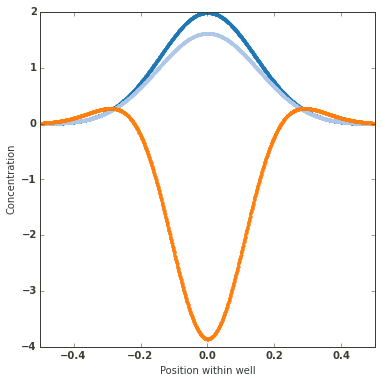

In [47]:
n_modes = 20
gamval = 1e8
kval = 1.e6
Dval = 1.e1
bk = 100
Lval=1.0
alpval = 1.0

xvals = linspace(-2*Lval,2**Lval,5000)

(x,y) = meshgrid(range(n_modes), range(n_modes))

times = linspace(0,.0004,3)

# pre-compute the little-a matrix
amat_full = matcrunch(amat_1dharmonic(x,y, gam=gamval,kappa=kval))

all_coeffs = list()

figure()
hold(True)
for time in times:
    gmat_full = matcrunch(gmat(x,y, t=time,betak=bk, D=Dval, alp=alpval))
    tmat = expm_exact(amat_full*gmat_full)
    coeffs = zeros(n_modes/2) # remove the factor of two if symmetry goes away
    coeffs[0] = 1.0
    coeffs = tmat.dot(coeffs)
    sol = sum_eigen_harmonic(xvals,coeffs,ignore='odd', betak=bk)
    plot(xvals, sol,'.')
    all_coeffs.append(coeffs)
#     plot(time,sum(coeffs),'.',markersize=20)
    print("time: " + str(time))

xlim([-.5*Lval, .5*Lval])

rcParams['font.family'] = 'Myriad Pro Bold'
xlabel('Position within well')
ylabel('Concentration')
# savefig('xxdraining.pdf')

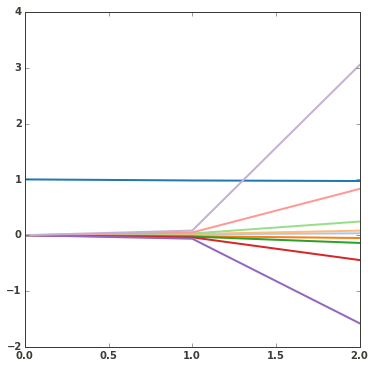

In [46]:
plot(array(all_coeffs))
print('')

The first row of the matrix that operates on the stationary state, the elements of this first frow are responsible for hte spreading

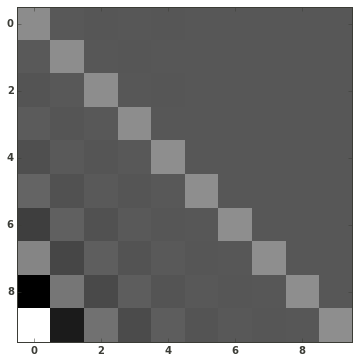

In [38]:
imshow(tmat)

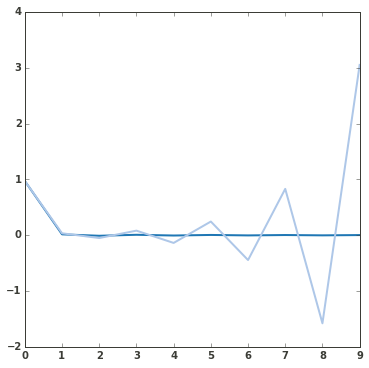

In [40]:
plot(tmat[0,:])
hold(True)
plot(tmat[:, 0])

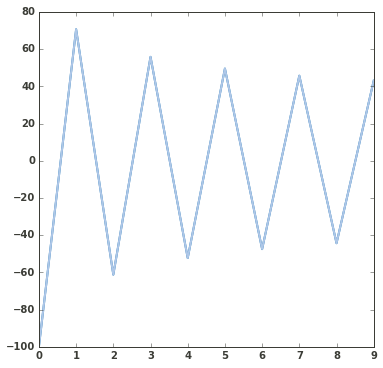

In [43]:
plot(amat_full[0,:])
hold(True)
plot(amat_full[:, 0])